# Desarrollo proyecto VQA por Joaquin Zepeda

A continuación se presenta la recopilación de los códigos realizados para la tarea, debido a que el entrenamiento podia demorar más de una hora, se realizaron distintos archivos para ejecutarse en paralelo de forma de ser más eficiente, todo esto se recopila en este archivo.

# Desacarga de los datos

In [ ]:
# Download datasete
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Train_abstract_v002.zip
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Val_abstract_v002.zip
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_train2015.zip
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_val2015.zip
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Train_abstract_v002.zip
!wget -q -N --show-progress https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Val_abstract_v002.zip

!mkdir -p {Questions/train Questions/test Questions/val Images/train Images/test Images/val Annotations/train Annotations/val}

!unzip -q -n Questions_Train_abstract_v002.zip -d Questions
!unzip -q -n Questions_Val_abstract_v002.zip -d Questions
!unzip -q -n scene_img_abstract_v002_train2015.zip -d Images/train
!unzip -q -n scene_img_abstract_v002_val2015.zip -d Images/val
!unzip -q -n Annotations_Train_abstract_v002.zip -d Annotations
!unzip -q -n Annotations_Val_abstract_v002.zip -d Annotations

Questions_Train_abs 100%[===================>]   4.39M  2.82MB/s    in 1.6s    
Questions_Val_abstr 100%[===================>]   2.13M  1.58MB/s    in 1.4s    
scene_img_abstract_ 100%[===================>]   2.71G  8.74MB/s    in 4m 19s  
scene_img_abstract_ 100%[===================>]   1.35G  8.31MB/s    in 2m 32s  
Annotations_Train_a 100%[===================>]   2.53M  1.63MB/s    in 1.6s    
Annotations_Val_abs 100%[===================>]   1.26M   963KB/s    in 1.3s    


In [ ]:
# Remove unnecessary zip files.

!rm Questions_Train_abstract_v002.zip
!rm Questions_Val_abstract_v002.zip

!rm scene_img_abstract_v002_train2015.zip
!rm scene_img_abstract_v002_val2015.zip

!rm Annotations_Train_abstract_v002.zip
!rm Annotations_Val_abstract_v002.zip
##########################################################

### Inicializamos las semillas

In [ ]:
import torch
import numpy as np
import random

SEED = 1234


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Flag BOW

Si BOW es True, se ejecuta todo lo correspondiente a la primera implementación, la cual corresponde a un modulo de lenguaje BOW + un modulo de vision VGG19 + MLP. En caso contrario se ejecuta la segunda implementación la cual cambia el modelo de lenguaje por una LSTM y mantiene lo demás.

In [ ]:
BOW = True

# Codificando las palabras

Vamos a representar cada palabra con un único número entero que representará su índice.
Para eso construiremos un diccionario que mapee palabras a números. La verdad es que son muy similares los vocabularios, hay muy pequeños cambios.

## Vocabulario para el BoW

Se separan los vocabularios para las preguntas y para las respuestas.

In [ ]:
import re
from string import punctuation
import os
import numpy as np
from collections import defaultdict
import json

def make_bow_qst_vocabulary(input_dir,n_words):
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    questions_dict = dict()
    preguntas = []
    datasets = os.listdir(input_dir)
    for dataset in ['MultipleChoice_abstract_v002_train2015_questions.json','MultipleChoice_abstract_v002_val2015_questions.json']:
        with open(input_dir+'/'+dataset) as f:
            questions = json.load(f)['questions']
        for question in questions:
            all_text = question['question'].lower()
            all_text = ''.join([c for c in all_text if c not in punctuation])
            words = SENTENCE_SPLIT_REGEX.split(all_text)
            preguntas.append(all_text)
            for word in words:
                word=word.strip()                
                if word not in questions_dict:
                    questions_dict[word] = 1                
                if re.search(r"[^\w\s]", word):
                    continue
                questions_dict[word] += 1                
    questions_dict = sorted( questions_dict, key= questions_dict.get, reverse=True)
    top_answers = ['<unk>'] +  questions_dict[:n_words-1] # '-1' is due to '<unk>'
    
    return top_answers,  questions_dict[:n_words], preguntas

def make_bow_ans_vocabulary(input_dir,n_words):
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    ans_dict = dict()
    datasets = os.listdir(input_dir)
    answers = []
    for dataset in ['abstract_v002_train2015_annotations.json','abstract_v002_val2015_annotations.json']:
        with open(input_dir+'/'+dataset) as f:
            annotations = json.load(f)['annotations']
        for annotation in annotations:
            for answer in annotation['answers']:
                word = answer['answer'].strip()
                if re.search(r"[^\w\s]", word):
                    continue
                if word not in ans_dict:
                    ans_dict[word] = 1
                ans_dict[word] += 1
                
    ans_dict = sorted( ans_dict, key= ans_dict.get, reverse=True)
    top_answers = ans_dict[:n_words-1] # '-1' is due to '<unk>'
    
    return top_answers,  ans_dict[:n_words]

## Vocabulario para la LSTM

Se separan nuevamente los vocabularios para las preguntas y respuestas.

In [ ]:
import re
from string import punctuation
import os
import numpy as np
from collections import defaultdict

def make_vocab_questions(input_dir):
    """Genera un vocabulario y lo guarda en una lista y diccionario"""
    vocab_set = set()
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question_length = []
    datasets = os.listdir(input_dir)
    preguntas = []
    print('Se eliminan los signos de puntuación: ',punctuation)
    for dataset in ['MultipleChoice_abstract_v002_train2015_questions.json','MultipleChoice_abstract_v002_val2015_questions.json']:
        a = 0    
        with open(input_dir+'/'+dataset) as f:
            questions = json.load(f)['questions']
            if a==0:
                print(questions[0]['question'])
            a+=1
        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            all_text = question['question'].lower()
            all_text = ''.join([c for c in all_text if c not in punctuation])

            words = SENTENCE_SPLIT_REGEX.split(all_text)
            preguntas.append(all_text)
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

    vocab_list = list(vocab_set)
    vocab_list.sort()
    # se agregan 2 preguntas especiales para casos desconocidos
    vocab_list.insert(0, '<pad>')
    vocab_list.insert(1, '<unk>')
    
    print('Estamos haciendo un vocabulario con todas las palabras de todas las preguntas')
    print('El número total de palabras en las preguntas son: %d' % len(vocab_set))
    print('El largo máximo de una pregunta es: %d' % np.max(question_length))

    return vocab_list, preguntas


def make_vocab_answers(input_dir, n_answers):
    """Vocabulario con el top n_answers, retorna la lista con el top y las respuestas."""
    answers = defaultdict(lambda: 0)
    datasets = os.listdir(input_dir)
    for dataset in ['abstract_v002_train2015_annotations.json','abstract_v002_val2015_annotations.json']:
        with open(input_dir+'/'+dataset) as f:
            annotations = json.load(f)['annotations']
        for annotation in annotations:
            for answer in annotation['answers']:
                word = answer['answer']
                if re.search(r"[^\w\s]", word):
                    continue
                answers[word] += 1
                
    answers = sorted(answers, key=answers.get, reverse=True)
    assert('<unk>' not in answers)
    top_answers = ['<unk>'] + answers[:n_answers-1] # '-1' is due to '<unk>'
    
    print('Vocabulario para las respuestas')
    print('Número total de respuestas: %d' % len(answers))
    print('Guarda el %d de respuestas' % n_answers)
    return top_answers, answers

In [ ]:
def lookUpBOW(top_words, bow_dict,all_words):
    """Función auxiliar para generar una Look up table"""
    bow_qns = np.zeros((len(all_words), 1024))

    for i in range(len(all_words)):
        w = all_words[i]
        s =  w.split()
        for word in s:
            if word not in top_words:
                idx = 0
            else:
                idx = top_words.index(word)
            # se suma uno por las palabras repetidas
            bow_qns[i][idx] += 1
    return bow_qns

In [ ]:
if bow:
    # Se generan los vocabularios y las tablas para ver el funcionameinto.
    top_questionsBOW,  qst_bow_dict, preguntas = make_bow_qst_vocabulary("Questions",1024)
    top_answersBOW,  ans_bow_dict = make_bow_ans_vocabulary("Annotations",1000)

    qst_bow_table = lookUpBOW(top_questionsBOW,  qst_bow_dict, preguntas)
    ans_bow_table = lookUpBOW(top_answersBOW,  ans_bow_dict, top_answersBOW)

### Pruebas

In [ ]:
print("Question",preguntas[0])
print("Question Bow",qst_bow_table[0])
print("Answer",top_answersBOW[0])
print("Answer Bow",ans_bow_table[0])
print("Indice answer",np.argmax(ans_bow_table[0]))

Question who looks happier
Question Bow [1. 0. 0. ... 0. 0. 0.]
Answer [1. 0. 0. ... 0. 0. 0.]
Answer Bow [1. 0. 0. ... 0. 0. 0.]
Indice answer 0


## Funciones auxiliares para LSTM

Se genera un diccionario para acceder a los indices de las palabras y transformar las palabras e indices de forma bidireccional. Cabe destacar que se eliminan los caracteres especiales, solo se consideran las palabras. Algunas de estas funciones se extrajeron del repositorio basic_vqa que se puede encontrar en las referencias del informe.

In [ ]:
import re

SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')

def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens
def load_str_list(fname):
    with open(fname) as f:
        lines = f.readlines()
    lines = [l.strip() for l in lines]
    return lines


class VocabDict:

    def __init__(self, word_list):
        self.word_list = word_list
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError('word %s not in dictionary (while dictionary does not contain <unk>)' % w)

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]
        return 

# Dataset personalizados

## Dataset BoW

In [ ]:
import json
import torch
import os
from torch.utils.data import Dataset
from skimage import io
import numpy as np
from torchvision import transforms
from PIL import Image

class VQA_BOW(Dataset):
  def __init__(self, questions_path: str, annotations_path: str, images_folder_path: str, transform ,max_qst_length=30, max_num_ans=10):
    super(VQA_BOW, self).__init__()
    self.qn_path = questions_path
    self.an_path = annotations_path
    self.img_path = images_folder_path

    self.transform = transform

    top_questionsBOW,  qst_bow_dict, preguntas = make_bow_qst_vocabulary("Questions",1024)
    top_answersBOW,  ans_bow_dict = make_bow_ans_vocabulary("Annotations",1000)

    self.top_answers = top_answersBOW

    qst_bow_table = lookUpBOW(top_questionsBOW,  qst_bow_dict, preguntas)
    ans_bow_table = lookUpBOW(top_answersBOW,  ans_bow_dict , top_answersBOW)

    self.qst_bow_table = qst_bow_table
    self.ans_bow_table = ans_bow_table

    self.max_qst_length = max_qst_length
    self.max_num_ans = max_num_ans

    self.ann_dataset = json.load(open(self.an_path, 'r'))['annotations']
    qn_json = json.load(open(self.qn_path, 'r'))
    self.qn_dataset = qn_json['questions']
    self.img_prefix = f"{qn_json['data_type']}_{qn_json['data_subtype']}"
  
  def __len__(self):
    return len(self.qn_dataset)

  def __getitem__(self, item: int):

    qst_bow_table = self.qst_bow_table
    ans_bow_table = self.ans_bow_table
    max_qst_length = self.max_qst_length
    max_num_ans = self.max_num_ans

    
    question = self.qn_dataset[item]
    question_str = question['question']

    qst_vec = qst_bow_table[item]

    choices = question['multiple_choices']

    answer = self.ann_dataset[item]['multiple_choice_answer']
    
    ans2idx = 0
    if answer in self.top_answers:
        #indice de la respuesta
        ans2idx = self.top_answers.index(answer)

    image = Image.open(os.path.join(self.img_path, f"{self.img_prefix}_{question['image_id']:012d}.png")).convert('RGB')
    if self.transform:
      image = self.transform(image)    
    
    return image, question_str, choices, answer, qst_vec, ans2idx


## Dataset LSTM

In [ ]:
import json
import torch
import os
from torch.utils.data import Dataset
from skimage import io
import numpy as np
from torchvision import transforms
from PIL import Image

class VQA_LSTM(Dataset):
  def __init__(self, questions_path: str, annotations_path: str, images_folder_path: str, transform ,max_qst_length=30, max_num_ans=10):
    super(VQA_LSTM, self).__init__()
    self.qn_path = questions_path
    self.an_path = annotations_path
    self.img_path = images_folder_path

    self.transform = transform

    #retorna una lista con un vocabulario de preguntas
    vocab_list, _ = make_vocab_questions('Questions')
    #retorna una lista con el top 1000 respuestas
    top_answers, _ = make_vocab_answers('Annotations',1000)

    #Diccionario de preguntas
    self.qst_vocab = VocabDict(vocab_list)
    #Diccionario de respuestas
    self.ans_vocab = VocabDict(top_answers)

    self.max_qst_length = max_qst_length
    self.max_num_ans = max_num_ans

    self.ann_dataset = json.load(open(self.an_path, 'r'))['annotations']
    qn_json = json.load(open(self.qn_path, 'r'))
    self.qn_dataset = qn_json['questions']
    self.img_prefix = f"{qn_json['data_type']}_{qn_json['data_subtype']}"
  
  def __len__(self):
    return len(self.qn_dataset)

  def __getitem__(self, item: int):

    qst_vocab = self.qst_vocab
    ans_vocab = self.ans_vocab
    max_qst_length = self.max_qst_length
    max_num_ans = self.max_num_ans

    
    question = self.qn_dataset[item]
    question_str = question['question']

    qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
    qst2idc[:len(tokenize(question['question']))] = [qst_vocab.word2idx(w) for w in tokenize(question['question'])]

    choices = question['multiple_choices']

    answer = self.ann_dataset[item]['multiple_choice_answer']
    ans2idx = ans_vocab.word2idx(answer)

    image = Image.open(os.path.join(self.img_path, f"{self.img_prefix}_{question['image_id']:012d}.png")).convert('RGB')
    if self.transform:
      image = self.transform(image)    

    return image, question_str, choices, answer, qst2idc, ans2idx

In [ ]:
# trabajo con listas
L = ['2', 'yes', 'man on table', 'out on porch', 'cotton', '1', '3', 'blue', 'white', 'brown', 'no', 'yard', 'sandals', 'on deck', '4', 'pot', 'red', 'on grass']
L.index('on grass'),L[17]

(17, 'on grass')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if not bow:
    questions_path='Questions'
    annotation_path='Annotations'

    #generamos los archivos que despues se utilizan para generar el diccionario de preguntas
    qvocab_list, preguntas = make_vocab_questions(questions_path)
    #generamos los archivos que despues se utilizan para generar el diccionario de respuestas
    top_answers, answers = make_vocab_answers(annotation_path,1000)

    # Uso
    dataset = VQA_LSTM(questions_path='Questions/MultipleChoice_abstract_v002_val2015_questions.json', 
                annotations_path='Annotations/abstract_v002_val2015_annotations.json',
                images_folder_path='Images/val/', transform=transforms.Compose([
                                                        transforms. ToTensor(),
                                                        transforms.Resize((224,224))
                                                    ]))

    # Tomar muestra aleatoria
    image, question, choices, answer, qst2idc, anslabel = dataset[50]

    print("Dimension de la imagen:",image.shape)
    print(question,qst2idc)
    print("Alternativas:",choices)
    print("Indice de la solución",anslabel)


    # Visualizar
    img = image.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.suptitle(f"{question}")
    plt.title(f"{answer}")
    plt.axis('off')
    plt.show()

Se eliminan los signos de puntuación:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Who looks happier?
Is the dog asleep?
Estamos haciendo un vocabulario con todas las palabras de todas las preguntas
El número total de palabras en las preguntas son: 5346
El largo máximo de una pregunta es: 21
Make vocabulary for answers
The number of total words of answers: 24058
Keep top 1000 answers into vocab


Dimension de la imagen: torch.Size([3, 224, 224])
Is the grass green? [0. 0. 2. ... 0. 0. 0.]
Alternativas: ['exploring', 'no idea', 'to eat', '1', 'white', 'coat', 'not sure', 'red', '3', 'blue', 'football, soccer', '2', "she's playing with her cat", 'yes', 'no', '4', 'for fun', 'brown']
Indice de la solución 0


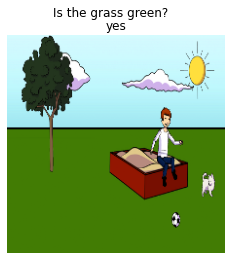

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if bow:
    # Uso
    dataset = VQA_BOW(questions_path='Questions/MultipleChoice_abstract_v002_val2015_questions.json', 
                annotations_path='Annotations/abstract_v002_val2015_annotations.json',
                images_folder_path='Images/val/', transform=transforms.Compose([
                                                        transforms. ToTensor(),
                                                        transforms.Resize((224,224))
                                                    ]))

    # Tomar muestra aleatoria
    image, question, choices, answer, qst2idc, anslabel = dataset[50]

    print("Dimension de la imagen:",image.shape)
    print(question,qst2idc)
    print("Alternativas:",choices)
    print("Indice de la solución",anslabel)
    #print("Solución BOW",top_answersBOW[anslabel])

    # Visualizar
    img = image.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.suptitle(f"{question}")
    plt.title(f"{answer}")
    plt.axis('off')
    plt.show()

In [ ]:
#El indice de yes es el 1, entonces de las mil salidas la neurona con mayor probailidad deberia ser esa
top_answers[0:5], len(top_answers)

(['<unk>', 'yes', 'no', '2', '1'], 1000)

# Generando los dataset

Se generan los dataset para cada modelo.

In [ ]:
BATCH_SIZE = 64
if bow == True:
    trainDatasetBOW = VQA_BOW(questions_path='Questions/MultipleChoice_abstract_v002_train2015_questions.json', 
              annotations_path='Annotations/abstract_v002_train2015_annotations.json',
              images_folder_path='Images/train/',  transform=transforms.Compose([
                                                    transforms. ToTensor(),
                                                    transforms.Resize((224,224))
                                                ]))
    valDatasetBOW   = VQA_BOW(questions_path='Questions/MultipleChoice_abstract_v002_val2015_questions.json', 
                annotations_path='Annotations/abstract_v002_val2015_annotations.json',
                images_folder_path='Images/val/',  transform=transforms.Compose([
                                                        transforms. ToTensor(),
                                                        transforms.Resize((224,224))
                                                    ]))
    train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

else:
    trainDataset = VQA_LSTM(questions_path='Questions/MultipleChoice_abstract_v002_train2015_questions.json', 
                annotations_path='Annotations/abstract_v002_train2015_annotations.json',
                images_folder_path='Images/train/',  transform=transforms.Compose([
                                                        transforms. ToTensor(),
                                                        transforms.Resize((224,224))
                                                    ]))
    valDataset   = VQA_LSTM(questions_path='Questions/MultipleChoice_abstract_v002_val2015_questions.json', 
                annotations_path='Annotations/abstract_v002_val2015_annotations.json',
                images_folder_path='Images/val/',  transform=transforms.Compose([
                                                        transforms. ToTensor(),
                                                        transforms.Resize((224,224))
                                                    ]))
    train_loaderBOW = torch.utils.data.DataLoader(trainDatasetBOW, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loaderBOW = torch.utils.data.DataLoader(valDatasetBOW, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Se eliminan los signos de puntuación:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Who looks happier?
Is the dog asleep?
Estamos haciendo un vocabulario con todas las palabras de todas las preguntas
El número total de palabras en las preguntas son: 5346
El largo máximo de una pregunta es: 21
Make vocabulary for answers
The number of total words of answers: 24058
Keep top 1000 answers into vocab
Se eliminan los signos de puntuación:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Who looks happier?
Is the dog asleep?
Estamos haciendo un vocabulario con todas las palabras de todas las preguntas
El número total de palabras en las preguntas son: 5346
El largo máximo de una pregunta es: 21
Make vocabulary for answers
The number of total words of answers: 24058
Keep top 1000 answers into vocab


# Generando modelos



## Primer modelo

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


class ImgEncoderBOW(nn.Module):

    def __init__(self, embed_size):
        """Red VGG19 preentrenada con los pesos de imagenet
        """
        super(ImgEncoderBOW, self).__init__()
        model = models.vgg19(pretrained=True)
        in_features = model.classifier[-1].in_features  # input size of feature vector
        model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])    # remove last fc layer

        self.model = model                              # loaded model without last fc layer
        self.fc = nn.Linear(in_features, embed_size)    # feature vector of image

    def forward(self, image):
        """Extract feature vector from image vector.
        """
        #image = image.permute(0, 3, 1, 2)
        with torch.no_grad():
            img_feature = self.model(image)                  # [batch_size, vgg16(19)_fc=4096]
        img_feature = self.fc(img_feature)                   # [batch_size, embed_size]

        l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        img_feature = img_feature.div(l2_norm)               # l2-normalized feature vector

        return img_feature

class VqaModelBOW(nn.Module):

    def __init__(self, embed_size, qst_vocab_size, word_embed_size, num_layers, hidden_size):

        super(VqaModelBOW, self).__init__()
        self.img_encoder = ImgEncoderBOW(embed_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_size, 1000)
        self.fc2 = nn.Linear(1000, 1000)

    def forward(self, img, qst_feature):
        #se le pasa de forma directa el BoW encoding
        img_feature = self.img_encoder(img)                    
        combined_feature = torch.mul(img_feature, qst_feature)  
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc1(combined_feature)          
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc2(combined_feature)        

        return combined_feature

## Segundo modelo 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


class ImgEncoder(nn.Module):

    def __init__(self, embed_size):
        """Feature vector de la VGG19 preentrenada con los pesos de imagenet
        """
        super(ImgEncoder, self).__init__()
        model = models.vgg19(pretrained=True)
        in_features = model.classifier[-1].in_features  # input size of feature vector
        model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])    # remove last fc layer

        self.model = model                              # loaded model without last fc layer
        self.fc = nn.Linear(in_features, embed_size)    # feature vector of image 4096->1000

    def forward(self, image):
        """Se extraen las caracteristicas
        """
        #image = image.permute(0, 3, 1, 2)
        with torch.no_grad():
            img_feature = self.model(image)            
        img_feature = self.fc(img_feature)                   

        l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        img_feature = img_feature.div(l2_norm)          # se normaliza

        return img_feature


class QstEncoder(nn.Module):
    """Red neuronal recurrente LSTM"""

    def __init__(self, qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size):

        super(QstEncoder, self).__init__()
        self.word2vec = nn.Embedding(qst_vocab_size, word_embed_size)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(2*num_layers*hidden_size, embed_size)   
        #LSTM con salida de tamaño 1024
        
    def forward(self, question):

        qst_vec = self.word2vec(question)                             
        qst_vec = self.tanh(qst_vec)
        qst_vec = qst_vec.transpose(0, 1)                             
        _, (hidden, cell) = self.lstm(qst_vec)                      
        qst_feature = torch.cat((hidden, cell), 2)                    
        qst_feature = qst_feature.transpose(0, 1)                  
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1) 
        qst_feature = self.tanh(qst_feature)
        qst_feature = self.fc(qst_feature)                            

        return qst_feature


class VqaModel(nn.Module):

    def __init__(self, embed_size, qst_vocab_size, word_embed_size, num_layers, hidden_size):

        super(VqaModel, self).__init__()
        self.img_encoder = ImgEncoder(embed_size)
        self.qst_encoder = QstEncoder(qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_size, 1000)
        self.fc2 = nn.Linear(1000, 1000)

    def forward(self, img, qst):
        img_feature = self.img_encoder(img)                     
        qst_feature = self.qst_encoder(qst)                     
        combined_feature = torch.mul(img_feature, qst_feature)  
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc1(combined_feature)          
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc2(combined_feature)      #salida de 1000    

        return combined_feature

In [ ]:
if not bow:
    qst_vocab_size = train_loader.dataset.qst_vocab.vocab_size
    ans_vocab_size = 1000
embed_size = 1024
word_embed_size = 300
num_layers = 2
hidden_size = 512
learning_rate = 0.001

In [ ]:
print("Tamaño de los vocabularios, question vocab size: ",qst_vocab_size,"answer vocab size",ans_vocab_size)

Tamaño de los vocabularios, question vocab size:  5348 answer vocab size 1000


In [ ]:
print(len(train_loader.dataset),len(val_loader.dataset))

60000 30000


In [ ]:
print("Tamaño de los vocabularios, question vocab size: ",qst_vocab_size,"answer vocab size",ans_vocab_size)

Tamaño de los vocabularios, question vocab size:  5348 answer vocab size 1000


In [ ]:
print(len(train_loader.dataset),len(val_loader.dataset))

60000 30000


# Train function

## Device

Se utiliza el entorno GPU.

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## Función Train para el primer modelo

En base a los modelos de la tarea 5 y del curso Deep learning.

In [ ]:
import time
import copy

def trainBOW(net, optimizer, num_epocas):
    inicio = time.time()

    #copiamos el modelo utilizando la libreria copy
    best_model_wts = copy.deepcopy(net.state_dict()) 
    train_losses, train_counter, train_accuracy, val_losses,val_accuracy,val_counter  = [],[],[],[],[],[]
    
    best_acc = 0.0
    best_loss = 2e32
    for epoch in range(num_epocas):
        print('Epoch {}/{}'.format(epoch, num_epocas-1))
        print('-' * 10)

        net.train() #Modo entrenamiento

        running_loss = 0.0
        running_corrects = 0.0
        batch_size = 64
        batch_step_size = len(train_loaderBOW.dataset) / batch_size
        a=0
        for batch_idx, batch_sample in enumerate(train_loaderBOW):
            image = batch_sample[0].to(device).float()
            question = batch_sample[4].to(device).float()
            label = batch_sample[5].to(device)
            optimizer.zero_grad()
            if a==0:
              print(image.shape,question.shape,label.shape)
              print("question",question[0])
              print("label",label[0])
              a+=1

            output = net(image,question) #salidas de la red
            pred_indices = torch.argmax(output,1)  # [batch_size]
            loss = criterion(output, label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += torch.sum(pred_indices == label.data)
            if batch_idx %100 == 0:
                print('Batch idx: ',batch_idx,' Batch Step: ' ,int(batch_step_size)) #para ver el avance

        epoch_loss = running_loss /len(train_loaderBOW.dataset) #promedio de error 
        epoch_acc = running_corrects / len(train_loaderBOW.dataset) #promedio de accuracy
        train_losses.append(epoch_loss)
        train_counter.append(epoch)
        train_accuracy.append(epoch_acc)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        #Validacion 
        net.eval()

        running_loss = 0.0
        running_corrects = 0.0
        for batch_idx, batch_sample in enumerate(val_loaderBOW):
            image = batch_sample[0].to(device).float()
            question = batch_sample[4].to(device).float()
            label = batch_sample[5].to(device)
            with torch.set_grad_enabled(False):
                output = net(image,question) #salidas de la red
                _, pred_indices = torch.max(output, 1)  # [batch_size]
                loss = criterion(output, label)
 
                running_loss += loss.item()
                running_corrects += torch.sum(pred_indices == label)
        
        epoch_loss = running_loss /len(val_loaderBOW.dataset) #promedio de error 
        epoch_acc = running_corrects / len(val_loaderBOW.dataset) #promedio de accuracy
        val_losses.append(epoch_loss)
        val_counter.append(epoch)
        val_accuracy.append(epoch_acc)
        #chekpoint
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(net.state_dict())
        
        # early stopping, si el error aumenta más de 5 veces respecto al menor error,
        # terminamos el entrenamiento
        if epoch_loss > best_loss*5:
            print('\n'+'-' * 10+'Early Stopping'+'-' * 10+'\n')
            break

    print('Best val loss: {:.4f}'.format(best_loss))

    final = time.time()
    print('Training complete in {:.0f}m {:.0f}s'.format((final-inicio)//60, (final-inicio) % 60))

    net.load_state_dict(best_model_wts)
    return net, train_counter,train_losses,train_accuracy,val_counter,val_losses,val_accuracy

## Función train para el segundo modelo

In [ ]:
import time
import copy

def train(net, optimizer, num_epocas):
    inicio = time.time()

    ans_unk_idx = train_loader.dataset.ans_vocab.unk2idx

    #copiamos el modelo utilizando la libreria copy
    best_model_wts = copy.deepcopy(net.state_dict()) 
    train_losses, train_counter, train_accuracy, val_losses,val_accuracy,val_counter  = [],[],[],[],[],[]
    
    best_acc = 0.0
    best_loss = 2e32
    for epoch in range(num_epocas):
        print('Epoch {}/{}'.format(epoch, num_epocas-1))
        print('-' * 10)

        net.train() #Modo entrenamiento

        running_loss = 0.0
        running_corrects = 0.0
        batch_size = 64
        batch_step_size = len(train_loader.dataset) / batch_size
        for batch_idx, batch_sample in enumerate(train_loader):
            image = batch_sample[0].to(device).float()
            question = batch_sample[4].to(device).float()
            label = batch_sample[5].to(device)

            optimizer.zero_grad()

            output = net(image,question) #salidas de la red
            pred_indices = torch.argmax(output,1)  # [batch_size]
            loss = criterion(output, label)

            loss.backward()
            optimizer.step()

            #castigamos en caso de que la respuesta sea desconocida
            pred_indices[pred_indices == ans_unk_idx] = -9999
            running_loss += loss.item()
            running_corrects += torch.sum(pred_indices == label.data)
            if batch_idx %100 == 0:
                print('Batch idx: ',batch_idx,' Batch Step: ' ,int(batch_step_size))

        epoch_loss = running_loss /len(train_loader.dataset) #promedio de error 
        epoch_acc = running_corrects / len(train_loader.dataset) #promedio de accuracy
        train_losses.append(epoch_loss)
        train_counter.append(epoch)
        train_accuracy.append(epoch_acc)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        #Validacion 
        net.eval()

        running_loss = 0.0
        running_corrects = 0.0
        for batch_idx, batch_sample in enumerate(val_loader):
            image = batch_sample[0].to(device).float()
            question = batch_sample[4].to(device).float()
            label = batch_sample[5].to(device)
            with torch.set_grad_enabled(False):
                output = net(image,question) #salidas de la red
                _, pred_indices = torch.max(output, 1)  # [batch_size]
                loss = criterion(output, label)
 
                #castigamos en caso de que la respuesta sea desconocida
                pred_indices[pred_indices == ans_unk_idx] = -9999
                running_loss += loss.item()
                running_corrects += torch.sum(pred_indices == label)
        
        epoch_loss = running_loss /len(val_loader.dataset) #promedio de error 
        epoch_acc = running_corrects / len(val_loader.dataset) #promedio de accuracy
        val_losses.append(epoch_loss)
        val_counter.append(epoch)
        val_accuracy.append(epoch_acc)
        #chekpoint
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(net.state_dict())
        
        # early stopping, si el error aumenta más de 5 veces respecto al menor error,
        # terminamos el entrenamiento
        if epoch_loss > best_loss*5:
            print('\n'+'-' * 10+'Early Stopping'+'-' * 10+'\n')
            break

    print('Best val loss: {:.4f}'.format(best_loss))

    final = time.time()
    print('Training complete in {:.0f}m {:.0f}s'.format((final-inicio)//60, (final-inicio) % 60))

    net.load_state_dict(best_model_wts)
    return net, train_counter,train_losses,train_accuracy,val_counter,val_losses,val_accuracy

# Inicializando los modelos

Los demás parámetros se utilizan para generar el modelo del paper. 

* Utilizando Entropia cruzada.
* Adam optimizer.
* Bath Size de 64.
* Learning rate de 0.001 (tambien se realizaron experimentos variando este valor).

In [ ]:
if BOW == True:
    net = VqaModelBOW(embed_size, qst_vocab_size, ans_vocab_size, word_embed_size, num_layers, hidden_size)
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    
else:
    net = VqaModel(embed_size, qst_vocab_size, ans_vocab_size, word_embed_size, num_layers, hidden_size)
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    model, train_counter,train_loss,train_accuracy,val_counter,val_loss,val_accuracy = train(net, optimizer, num_epocas=6)


# Entrenamos

Se utilizan 6 epocas solamente debido al alto tiempo que toma entrenar.

In [ ]:
if BOW == True:
    model, train_counter,train_loss,train_accuracy,val_counter,val_loss,val_accuracy = trainBOW(net, optimizer, num_epocas=6)
else:
    model, train_counter,train_loss,train_accuracy,val_counter,val_loss,val_accuracy = train(net, optimizer, num_epocas=6)

Epoch 0/5
----------
torch.Size([64, 3, 224, 224]) torch.Size([64, 1024]) torch.Size([64])
question tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
label tensor(0, device='cuda:0')
Batch idx:  0  Batch Step:  937
Batch idx:  100  Batch Step:  937
Batch idx:  200  Batch Step:  937
Batch idx:  300  Batch Step:  937
Batch idx:  400  Batch Step:  937
Batch idx:  500  Batch Step:  937
Batch idx:  600  Batch Step:  937
Batch idx:  700  Batch Step:  937
Batch idx:  800  Batch Step:  937
Batch idx:  900  Batch Step:  937
Train Loss: 0.0536 Acc: 0.3191
Epoch 1/5
----------
torch.Size([64, 3, 224, 224]) torch.Size([64, 1024]) torch.Size([64])
question tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
label tensor(2, device='cuda:0')
Batch idx:  0  Batch Step:  937
Batch idx:  100  Batch Step:  937
Batch idx:  200  Batch Step:  937
Batch idx:  300  Batch Step:  937
Batch idx:  400  Batch Step:  937
Batch idx:  500  Batch Step:  937
Batch idx:  600  Batch Step:  937
Batch idx:  700  

In [ ]:
plt.figure()
#2b. Graficar las curvas de loss de entrenamiento y validación
plt.title(f"Loss curve Lr={learning_rate}")
plt.plot(train_counter, train_loss, label='Entrenamiento',color='blue')
plt.plot(val_counter,val_loss, label='Validacion',color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

train_accuracy_list = []
for x in train_accuracy:
  train_accuracy_list.append(x.cpu())

val_accuracy_list = []
for x in val_accuracy:
  val_accuracy_list.append(x.cpu())

plt.figure()
plt.title(f"Model Accuracy Lr={learning_rate}")
plt.plot(train_counter, train_accuracy_list, label='Entrenamiento',color='blue')
plt.plot(val_counter,val_accuracy_list, label='Validacion',color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print("Mayor accuracy en entrenamiento:",max(train_accuracy_list), "\nMayor accuracy en validación",max(val_accuracy_list))

In [ ]:
print("Menor loss en entrenamiento:",min(train_loss), "\nMenor loss en validación",min(val_loss))

# Visualizando los resultados en el conjunto de validación

In [ ]:
model.eval()

if BOW==True:
    val_loader = torch.utils.data.DataLoader(valDataset, batch_size=1, num_workers=2, pin_memory=True)

    for batch_idx, batch_sample in enumerate(val_loader):
        if batch_idx<10:
            image = batch_sample[0].to(device).float()
            question = batch_sample[4].to(device)
            label = batch_sample[5].to(device)
            with torch.set_grad_enabled(False):
                output = net(image,question) #salidas de la red
                _, pred_indice = torch.max(output, 1)  

            pred_answer = dataset.ans_vocab.idx2word(pred_indice)
            answer = dataset.ans_vocab.idx2word(label)
            question_str = ""
            for x in question[0]:
                if x!=0:
                    if dataset.qst_vocab.idx2word(x)=='<unk>':
                        question_str+='?'
                    else:
                        question_str+=dataset.qst_vocab.idx2word(x)+' '
                
            question_str
            print("\n")
            # Visualizar
            img = np.squeeze(image.cpu().numpy()).transpose((1, 2, 0))
            plt.imshow(img)
            plt.suptitle(f"{question_str}")
            plt.title(f"Real:{answer} - Pred:{pred_answer}")
            plt.axis('off')
            plt.show()

            time.sleep(1)

# Se guarda el modelo

In [ ]:
model = torch.save(model.state_dict(), "modelo.pth")